# The search for NNs evolved: trying parallel processing

First try in cross-matching two (mock) catalogs was done in notebook [xNN_mock_sources_v1](http://nbviewer.jupyter.org/github/chbrandt/pynotes/blob/429ea32977e7a0fb24e19a5b84f9ba3716d046dc/xmatch/xNN_mock_sources_v1.ipynb), where the workflow was setup.

Now, we take the chance to better build the algorithm and workout some parallelization in python.

TOC:
* [Simulation of source images](#Simulation-of-source-images)
  * [Resultant simulation for the first image/catalog](#Result-of-the-simulation-for-the-first-image)
  * [Resultant simulation for the second image/catalog](#Result-of-the-simulation-for-the-second-image)
  * [Resultant merged images](#Merge-images)
* [Cross-match the tables](#Cross-matching)
  * [Serial](#Serial-experiment)
  * [Parallel](#Parallel-experiment)
  * [Comparison of results](#Are-they-equal?)
* [Appendix](#[-This-is-for-another-notebook:-the-functions-organized-;])

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

## Simulation of source images


In [2]:
# first of all, let us define some parameters
#
# size of the images
sx = 5000
sy = 5000
# number of sources on each image
nsrc1 = int( 0.1 * (sx*sy)/(sx+sy) )
#nsrc2 = int( 0.5 * nsrc1 )
# typical error radius (in pixels)
rerr1 = 20
rerr2 = rerr1

In [3]:
# generate coordinate pairs for each image
def generate_positions(npts,img_shape):
    """
    Generate 'npts' points uniformly across 'image_shape'.
    
    Args:
        npts      : number of points to generate
        img_shape : (y,x) shape where to generate points

    Returns:
        Pair_Coordinates_List : list of (y,x) tuples
    """
    import numpy as np
    _sy,_sx = img_shape
    assert _sy>=5 and _sx>=5 # because I want
    indy = np.random.randint(0,_sy-1,npts)
    indx = np.random.randint(0,_sx-1,npts)
    _inds = zip(indy,indx)
    return _inds



def generate_positions_around(seeds,radius,img_shape,fraction=1.0):
    """
    """
    assert 0 < fraction <= 1.0
    
    def _gen_pos_around_individual(seed,radius,img_shape,fraction,distribution='normal'):
        """
        TODO: implement other kinds of distributions
        """
        from random import random
        if random() < fraction:
            import numpy as np
            sy,sx = seed
            y = int(np.random.normal(sy,radius))
            y = y if y > 0 and y < img_shape[0] else sy
            x = int(np.random.normal(sx,radius))
            x = x if x > 0 and x < img_shape[1] else sx
        else:
            y,x = generate_positions(1,img_shape)[0]
        return y,x
    
    _inds = []
    for seed in seeds:
        y,x = _gen_pos_around_individual(seed,radius,img_shape,fraction)
        _inds.append((y,x))
    return _inds


In [4]:
# "sources 1"
coords1 = generate_positions(nsrc1,(sy,sx))
assert isinstance(coords1,list)
assert len(coords1) == nsrc1

# "sources 2"
img_shape = (sy,sx)
coords2 = generate_positions_around(coords1,rerr1,img_shape,fraction=0.75)
assert isinstance(coords2,list)

In [5]:
# create the positions table
def create_positions_table(coords,err_radius):
    """
    """
    tab = {}
    for i,oo in enumerate(coords):
        i = i+1
        tab[i] = [i,oo[1],oo[0],err_radius]
    return tab

def tab2df(tab):
    nt = {'ID':[],'x':[],'y':[],'r':[]}
    for k,v in tab.iteritems():
        nt['ID'].append(v[0])
        nt['x'].append(v[1])
        nt['y'].append(v[2])
        nt['r'].append(v[3])
    import pandas
    df = pandas.DataFrame(nt)
    return df


In [6]:
# table for "sources 1" and a DataFrame for convenience...
tab1 = create_positions_table(coords1,rerr1)
df1 = tab2df(tab1)

# table for "sources 2"...
tab2 = create_positions_table(coords2,rerr2)
df2 = tab2df(tab2)

In [7]:
# create and draw each source on black(null) images
def draw_image_sources(tab_positions,img_shape,colormap='colorful'):
    """
    """
    def color_filling(mode='colorful'):
        def _colorful(x,y,size):
            _R = int(255 - ( int(x/256) + int(y/256)*(1 + ceil(size[0]/256)) )) #TODO: restrict total size of image to avoid _R<=0
            _G = x%256
            _B = y%256
            return (_R,_G,_B)

        def _blue(x,y,size):
            _R = 0
            _G = 0
            _B = 255
            return (_R,_G,_B)

        def _green(x,y,size):
            _R = 0
            _G = 255
            _B = 0
            return (_R,_G,_B)

        def _red(x,y,size):
            _R = 255
            _G = 0
            _B = 0
            return (_R,_G,_B)

        foos = {'blue'    : _blue,
                'red'     : _red,
                'green'   : _green,
                'colorful': _colorful}
        
        try:
            foo = foos[mode]
        except:
            foo = _colorful
        return foo
        
        
    from math import ceil
    from PIL import Image,ImageDraw
    assert(isinstance(img_shape,tuple) and len(img_shape) is 2)
    size = img_shape[::-1]
    # Modification to accomplish color codes ---
    #mode = 'L'
    mode = 'RGB'
    # ---
    color = "black"
    img = Image.new(mode,size,color)
    assert(len(tab_positions)>=1)
    #
    dictColorId = {}
    filling_foo = color_filling(colormap)
    #
    for i,src in tab_positions.items():
        assert isinstance(src,list) and src is tab_positions[i]
        assert len(src)>=4, "length of table raw %d is %d" % (i,len(src))
        assert i==src[0]
        draw = ImageDraw.Draw(img)
        x = src[1]
        assert 0<=x and x<size[0], "coordinate x is %d" % x
        y = src[2]
        assert 0<=y and y<size[1], "coordinate y is %d" % y
        r = src[3]
        assert r<size[0]/2 and r<size[1]/2
        box = (x-r,y-r,x+r,y+r)
        # Modification to accomplish color codes ---
        #fill=255
        fill = filling_foo(x,y,size)
        # ---
        dictColorId[str(fill)] = i
        draw.ellipse(box,fill=fill)
        del draw,box,x,y,r
    return img,dictColorId


In [8]:
img1,cor2id1 = draw_image_sources(tab1,(sy,sx),colormap='blue')
img2,cor2id2 = draw_image_sources(tab2,(sy,sx),colormap='red')
#img1.show()
#img2.show()

In [9]:
# cmap reference:
#
# cm api: http://matplotlib.org/api/cm_api.html
# cmaps : http://matplotlib.org/users/colormaps.html
# imshow: http://matplotlib.org/users/image_tutorial.html
#cmap = cm.get_cmap('Blues')

def pilImage_2_numpyArray(img):
    import numpy
    #img_array = numpy.array(list(img.getdata())).reshape(sx,sy,3)
    img_array = numpy.asarray(img)
    return img_array

def rgbArray_2_mono(img_arr,chanel='R'):
    chanels = {'R':0,
               'G':1,
               'B':2}
    _i = chanels[chanel]
    return img_arr[:,:,_i]


### Result of the simulation for the first image

Catalog A:
----------
      ID   r     x     y
0      1  20  3708  4304
1      2  20  4304   494
2      3  20   214  3537
3      4  20  1912  4540
4      5  20  4788  4431
5      6  20  4716  4808
6      7  20  1619  4183
7      8  20  1271  2960
8      9  20   525  1717
9     10  20  1941  1433
10    11  20  2897  4946
11    12  20   298  3576
12    13  20  3630  3544
13    14  20   730  3585
14    15  20  3680  2836
15    16  20   478   378
16    17  20  1791  2246
17    18  20  4473  4642
18    19  20  1824   476
19    20  20  3910  4762
20    21  20  2148  2417
21    22  20  4068  3836
22    23  20  3078  4157
23    24  20  2408  2921
24    25  20  2120  3191
25    26  20   621  1375
26    27  20   995  4408
27    28  20  2791  3183
28    29  20  4140  3489
29    30  20  2329   999
..   ...  ..   ...   ...
220  221  20  1991  3713
221  222  20  4682  4921
222  223  20  4424  3791
223  224  20  4713  2315
224  225  20   720  4803
225  226  20  2514   107
226  227  20  3330  2022
227

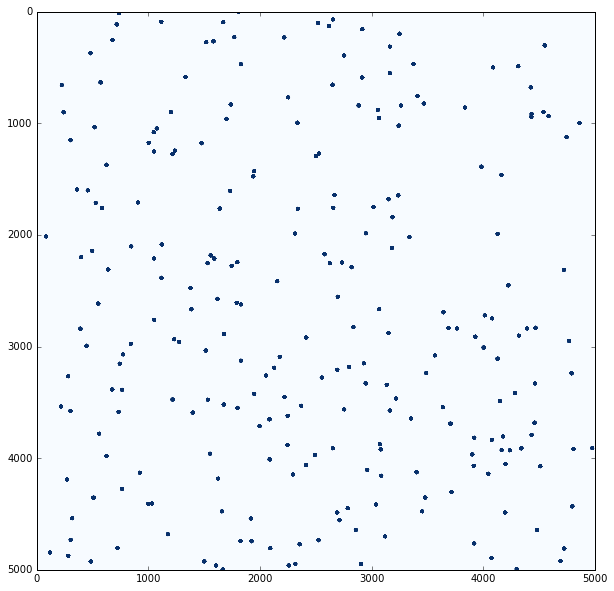

In [10]:
img1_array = pilImage_2_numpyArray(img1)
img1_mono = rgbArray_2_mono(img1_array,'B')

plt.imshow(img1_mono,cmap='Blues')
print "Catalog A:"
print "----------"
print df1

### Result of the simulation for the second image

Catalog B:
----------
      ID   r     x     y
0      1  20  3702  4282
1      2  20  4320   466
2      3  20  1403  3449
3      4  20  1910  4554
4      5  20  4764  4428
5      6  20  4709  4833
6      7  20  2899  1986
7      8  20  1294  2944
8      9  20  3827  3196
9     10  20  1952  1461
10    11  20  2878  4956
11    12  20   286  3578
12    13  20  3658  3568
13    14  20  3279  3774
14    15  20  1074  1742
15    16  20   502   403
16    17  20  1614  2585
17    18  20  4501  4666
18    19  20   287  4559
19    20  20  3921  4780
20    21  20  2146  2368
21    22  20  4077  3829
22    23  20  3065  4171
23    24  20  2395  2939
24    25  20  2120  3157
25    26  20  1350  4131
26    27  20   997  4409
27    28  20  2818  3196
28    29  20  4142  3502
29    30  20  2338  1012
..   ...  ..   ...   ...
220  221  20  2000  3731
221  222  20  4709  4942
222  223  20  4409  3814
223  224  20  4687  2315
224  225  20   722  4795
225  226  20  2513    86
226  227  20  3319  2040
227

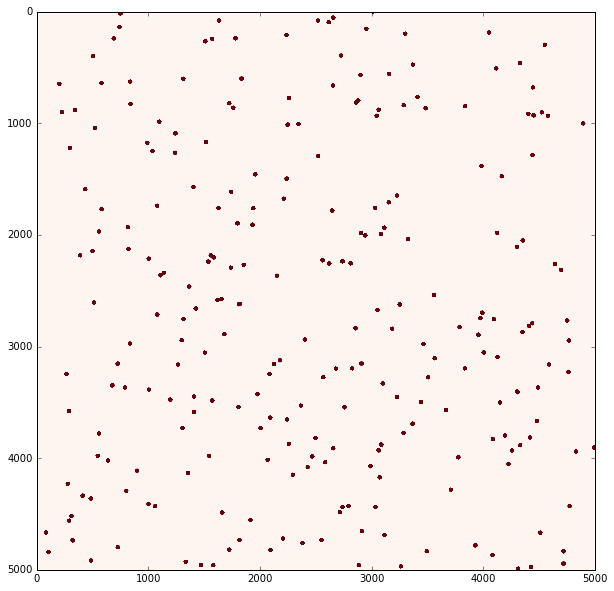

In [11]:
img2_array = pilImage_2_numpyArray(img2)
img2_mono = rgbArray_2_mono(img2_array,'R')

print "Catalog B:"
print "----------"
print df2
plt.imshow(img2_mono,cmap='Reds')

### Merge images

In [12]:
def add_arrays_2_image(img1,img2):
    """
    """
    def array_2_image(arr):
        from PIL import Image
        imgout = Image.fromarray(numpy.uint8(arr))
        return imgout
    return array_2_image(img1+img2)


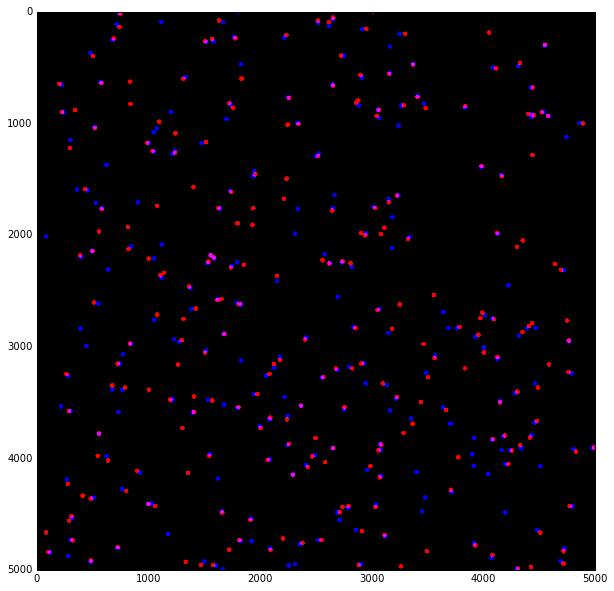

In [13]:
img_sum = add_arrays_2_image(img1_array,img2_array)
plt.imshow(img_sum)

## Cross-matching

### Serial experiment

In [14]:
def nn_search(catA,catB, dview=None):
    """
    """
    
    import pandas
    assert isinstance(catA,pandas.DataFrame)
    assert isinstance(catB,pandas.DataFrame)
    
    A = catA.copy()
    B = catB.copy()
    
    from astropy.coordinates import SkyCoord
    from astropy import units
    norm_fact = 500.0
    Ax_norm = A.x / norm_fact
    Ay_norm = A.y / norm_fact
    A_coord = SkyCoord(ra=Ax_norm, dec=Ay_norm, unit=units.deg)

    Bx_norm = B.x / norm_fact
    By_norm = B.y / norm_fact
    B_coord = SkyCoord(ra=Bx_norm, dec=By_norm, unit=units.deg)

    if dview:
        print "Running in parallel"
        # Encapsulate some variables to sand for processing
        def make_nn_search_parallel(foo,cat2):
            def pkg_nn_search(cat1,foo=foo,cat2=cat2):
                return foo(cat1,cat2)
            return pkg_nn_search

        # A-B
        from astropy.coordinates import match_coordinates_sky
        match_eps = make_nn_search_parallel(match_coordinates_sky,B_coord)
        #
        from numpy import arange,array_split,append
        A_list = [ A_coord[idx] for idx in array_split(arange(len(A_coord)),len(dview)) ]
        A_list_out = dview.map_sync(match_eps, A_list)
        #
        match_A_nn_idx, match_A_nn_sep = None, None
        for each_out in A_list_out:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_A_nn_idx is None:
                assert match_A_nn_sep is None
                match_A_nn_idx = match_idx
                match_A_nn_sep = match_sep.value
            else:
                match_A_nn_idx = append(match_A_nn_idx,match_idx)
                match_A_nn_sep = append(match_A_nn_sep,match_sep.value)

        # B-A
        from astropy.coordinates import match_coordinates_sky
        match_eps = make_nn_search_parallel(match_coordinates_sky,A_coord)
        #
        from numpy import arange,array_split,append
        B_list = [ B_coord[idx] for idx in array_split(arange(len(B_coord)),len(dview)) ]
        B_list_out = dview.map_sync(match_eps, B_list)
        #
        match_B_nn_idx, match_B_nn_sep = None, None
        for each_out in B_list_out:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_B_nn_idx is None:
                assert match_B_nn_sep is None
                match_B_nn_idx = match_idx
                match_B_nn_sep = match_sep.value
            else:
                match_B_nn_idx = append(match_B_nn_idx,match_idx)
                match_B_nn_sep = append(match_B_nn_sep,match_sep.value)
        
    else:
        print "Running in serial"
        from astropy.coordinates import match_coordinates_sky
        match_A_nn_idx, match_A_nn_sep, _d3d = match_coordinates_sky(A_coord, B_coord)
        match_B_nn_idx, match_B_nn_sep, _d3d = match_coordinates_sky(B_coord, A_coord)
        match_A_nn_sep = match_A_nn_sep.value
        match_B_nn_sep = match_B_nn_sep.value

    A['NN_in_B'] = B.ID[match_A_nn_idx].values
    B['NN_in_A'] = A.ID[match_B_nn_idx].values

    import numpy
    A_matched_pairs = zip(numpy.arange(len(match_A_nn_idx)),
                          match_A_nn_idx )
    B_matched_pairs = set(zip(match_B_nn_idx,
                              numpy.arange(len(match_B_nn_idx))))

    duplicate_pairs = []
    duplicate_dists = []
    for i,p in enumerate(A_matched_pairs):
        if p in B_matched_pairs:
            duplicate_pairs.append(p)
            duplicate_dists.append(match_A_nn_sep[i])

    A_matched_idx,B_matched_idx = zip(*duplicate_pairs)
    import pandas
    df_matched = pandas.DataFrame({ 'A_idx':A_matched_idx,
                                    'B_idx':B_matched_idx,
                                    'separation':duplicate_dists})
    df_matched = df_matched.set_index('A_idx')

    A.columns = [ 'A_'+c for c in A.columns ]
    B.columns = [ 'B_'+c for c in B.columns ]

    B_matched = B.iloc[df_matched.B_idx]
    B_matched['A_idx'] = df_matched.index
    B_matched = B_matched.set_index('A_idx')

    B_matched['dist'] = numpy.asarray(df_matched.separation * norm_fact, dtype=int)

    df = pandas.concat([A,B_matched],axis=1)
    return df


In [15]:
%time df_match_serial = nn_search(df1,df2)
# from astropy.table import Table
# table_match = Table.from_pandas( df_match )
# table_match.show_in_notebook()

Running in serial
CPU times: user 1.26 s, sys: 36.5 ms, total: 1.29 s
Wall time: 1.28 s


/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Parallel experiment

In [16]:
# Lets us see what happens in parallel
# First, run from the command line:
#$ ipcluster start -n 2

In [17]:
try:
    import ipyparallel as ipp
    client = ipp.Client()
    client.ids
    dview = client[:]
except:
    dview = None

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


In [18]:
%time df_match_parallel = nn_search(df1,df2,dview)

Running in serial
CPU times: user 331 ms, sys: 28.9 ms, total: 360 ms
Wall time: 331 ms


/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Are they equal?

In [19]:
df_match_parallel.equals(df_match_serial)

True

## [ This is for another notebook: the functions organized ;]

In [20]:
# ---

def read_catalogs(A_filename, B_filename, column_names, sample_size=0):
    """
    """

    def read_fitsio(filename,column_names=None):
        """
        """
        import fitsio
        if True:
            catalog_data = fitsio.read(filename, columns=column_names, ext=1)
        # else:
        #     catalog_data = fitsio.read(filename, ext=1)
        return catalog_data


    A_data = read_fitsio(A_filename, column_names=column_names[0])
    B_data = read_fitsio(B_filename, column_names=column_names[1])

    if sample_size:
        A_data = sample(A_data, fraction=sample_size)

    return A_data,B_data

# ---

def get_coordinates(ra,dec):
    from astropy.coordinates import SkyCoord
    from astropy import units
    return SkyCoord(ra=ra, dec=dec, unit=units.deg)

# ---

def sample(data_array, fraction=0.1):
    """
    Returns a (normal) random sample from array' rows

    Input:
     - data_array : ~numpy.ndarray
            Array from where rows are randomly chosen
     - fraction : int, float
            Number between (0,array'length); limits are non-inclusive.
            If the number is higher (inclusive) than '1', it is assumed to be
            the absolute value for the sample size; otherwise, if between (0,1)
            it is assumed to be the relative, array-length multiplication factor.
    Output:
     - sampled_array : ~numpy.ndarray
            Rows are randomly chosen from a normal distribution, all same columns
    """
    import numpy
    nrows = len(data_array)

    assert fraction > 0, "ValueError: There is no sense in asking for 'fraction' <= 0"
    assert fraction < nrows, "ValueError: There is no sense in asking for 'fraction' >= array's length"

    nsamp = fraction if fraction >= 1 else fraction*nrows
    nsamp = int(nsamp)
    idx = numpy.random.randint(0, nrows, nsamp)
    sample_data = data_array[idx]

    return sample_data

# ---

def xmatch_nn(A_coord,B_coord,parallel=False):
        if parallel:
            match_A_nn_idx, match_A_nn_sep = xmatch_nn_parallel(A_coord,B_coord)
        else:
            match_A_nn_idx, match_A_nn_sep = xmatch_nn_serial(A_coord,B_coord)
        return (match_A_nn_idx, match_A_nn_sep)

# ---

def xmatch_nn_serial(pin, neiborhood):
    """
    Nearest-Neighbor search

    Input:
     - pin : ~astropy.coordinates.SkyCoord
            reference catalog (catalog "A")
     - neiborhood : ~astropy.coordinates.SkyCoord
            matching catalog (catalog "B")

    Output:
     - tuple with ~numpy.ndarray , ~astropy.units.Quantity
            array of respective (to 'pin') index entries in 'neiborhood'
            , array of respective pair distances
    """
    A_coord = pin
    B_coord = neiborhood

    from astropy.coordinates import SkyCoord
    assert isinstance(A_coord,SkyCoord)
    assert isinstance(B_coord,SkyCoord)

    from astropy.coordinates import match_coordinates_sky
    match_A_nn_idx, match_A_nn_sep, _d3d = match_coordinates_sky(A_coord,B_coord)

    assert len(match_A_nn_idx) == len(A_coord)
    assert match_A_nn_idx.max() < len(B_coord)

    return (match_A_nn_idx, match_A_nn_sep.value)

# ---

def xmatch_nn_parallel(A_coord,B_coord,nprocs=2):
    """
    """
    
    def parallel_setup(nprocs=2):
        """
        Run xmatch in parallel

        It splits the first array in 'nprocs' for parallel processing,
        then it concatenates the outputs and return that.
        """
        #TODO: do all the verifications for parallel run

        # Lets us see what happens in parallel
        # First, run from the command line:
        #$ ipcluster start -n 2
        try:
            import ipyparallel as ipp
            client = ipp.Client()
            client.ids
            dview = client[:]
        except:
            dview = None
        return dview

    # ---

    dview = parallel_setup(nprocs=2)
    if not dview:
        return False

    print "Running in parallel"

    # Encapsulate some variables to send for processing
    def make_nn_search_parallel(foo,cat2):
        def pkg_nn_search(cat1,foo=foo,cat2=cat2):
            return foo(cat1,cat2)
        return pkg_nn_search
    # ---

    # Split array (of coordinates) in N pieces
    def split_array(A_coord,N):
        from numpy import arange,array_split
        index = arange(len(A_coord))
        A_pieces = [ A_coord[idx]   for idx in array_split( index,N ) ]
        return A_pieces

    # Join array/list of tuples in N pieces
    def join_array(A_coord_outs):
        from numpy import append
        match_A_nn_idx = None
        match_A_nn_sep = None
        for each_out in A_coord_outs:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_A_nn_idx is None:
                assert match_A_nn_sep is None
                match_A_nn_idx = match_idx
                match_A_nn_sep = match_sep.value
            else:
                match_A_nn_idx = append(match_A_nn_idx,match_idx)
                match_A_nn_sep = append(match_A_nn_sep,match_sep.value)
        return (match_A_nn_idx,match_A_nn_sep)
    # ---

    # A-B
    # from astropy.coordinates import match_coordinates_sky
    foo_match_coordinates = make_nn_search_parallel(xmatch_nn, B_coord)

    A_coord_pieces = split_array(A_coord,N=len(dview))

    A_coord_outs = dview.map_sync( foo_match_coordinates, A_coord_pieces )

    match_A_nn_idx,match_A_nn_sep = join_array(A_coord_outs)

    return (match_A_nn_idx,match_A_nn_sep.value)

# ---

def match_pairs(match_A_nn_idx,match_B_nn_idx,match_A_nn_sep):
    import numpy
    A_matched_pairs = zip(numpy.arange(len(match_A_nn_idx)),
                          match_A_nn_idx )
    B_matched_pairs = set(zip(match_B_nn_idx,
                          numpy.arange(len(match_B_nn_idx))))

    matched_pairs = []
    matched_dists = []
    for i,p in enumerate(A_matched_pairs):
        if p in B_matched_pairs:
            matched_pairs.append(p)
            matched_dists.append(match_A_nn_sep[i])

    A_matched_idx,B_matched_idx = zip(*matched_pairs)
    
    return (A_matched_idx, B_matched_idx, matched_dists)

# ---

def assemble_indexes(A_matched_idx,B_matched_idx,matched_dists):
    import pandas
    df_matched_idx = pandas.DataFrame({ 'A_idx':A_matched_idx,
                                        'B_idx':B_matched_idx,
                                        'separation':matched_dists})
    df_matched_idx = df_matched_idx.set_index('A_idx')
    return df_matched_idx

# ---

def merge_catalogs(A,B,df_matched_idx):

    A.columns = [ 'A_'+c for c in A.columns ]
    B.columns = [ 'B_'+c for c in B.columns ]

    B_matched = B.iloc[df_matched_idx.B_idx]
    B_matched['A_idx'] = df_matched_idx.index
    B_matched = B_matched.set_index('A_idx')

    B_matched['dist'] = numpy.asarray(df_matched_idx.separation)

    df = pandas.concat([ A,B_matched ],axis=1)
    
    return df

# ---


In [29]:
class Mock:
    @staticmethod
    def normalize_coordinates(A,B,norm_factor):

        def _normalize_coordinates(x, y, norm_fact):
            from astropy.coordinates import SkyCoord
            from astropy import units
            x_norm = x / norm_fact
            y_norm = y / norm_fact
            coord = SkyCoord(ra=x_norm, dec=y_norm, unit=units.deg)
            return coord

        A_coord = _normalize_coordinates(A.x,A.y,norm_factor)
        B_coord = _normalize_coordinates(B.x,B.y,norm_factor)
        return A_coord,B_coord

# ---
# A_filename = 'cs82/cs82.fits'
# B_filename = 'spies/spies.fits'

# column_names = (['OBJID','RA','DEC'],['id','RA_ch1','DEC_ch1'])
# A_data, B_data = read_catalogs(A_filename,B_filename,column_names)

# from astropy.table import Table
# A = Table(A_data)
# B = Table(B_data)

# A_coord = get_coordinates(A['RA'],A['DEC'])
# B_coord = get_coordinates(B['RA_ch1'],B['DEC_ch1'])

import pandas
assert isinstance(df1,pandas.DataFrame)
assert isinstance(df2,pandas.DataFrame)
A = df1.copy()
B = df2.copy()
norm_factor=500

A_coord,B_coord = Mock.normalize_coordinates(A, B, norm_factor)

match_A_nn_idx, match_A_nn_sep = xmatch_nn(A_coord, B_coord)
match_B_nn_idx, match_B_nn_sep = xmatch_nn(B_coord, A_coord)
del A_coord,B_coord

A_matched_idx, B_matched_idx, matched_dists = match_pairs(match_A_nn_idx, match_B_nn_idx, match_A_nn_sep)

import numpy
matched_dists = numpy.asarray([ _d * norm_factor for _d in matched_dists ], dtype=int)

df_matched_idx = assemble_indexes(A_matched_idx, B_matched_idx, matched_dists)
del A_matched_idx, B_matched_idx, matched_dists

matched_catalog = merge_catalogs(A,B,df_matched_idx)
del df_matched_idx

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/ipykernel/__main__.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
from astropy.table import Table
tab = Table.from_pandas(matched_catalog)
print tab

A_ID A_r A_x  A_y   B_ID B_r   B_x    B_y   dist
---- --- ---- ---- ----- ---- ------ ------ ----
   1  20 3708 4304   1.0 20.0 3702.0 4282.0 22.0
   2  20 4304  494   2.0 20.0 4320.0  466.0 32.0
   3  20  214 3537    --   --     --     --   --
   4  20 1912 4540   4.0 20.0 1910.0 4554.0 14.0
   5  20 4788 4431   5.0 20.0 4764.0 4428.0 23.0
   6  20 4716 4808   6.0 20.0 4709.0 4833.0 25.0
   7  20 1619 4183    --   --     --     --   --
   8  20 1271 2960   8.0 20.0 1294.0 2944.0 27.0
   9  20  525 1717    --   --     --     --   --
  10  20 1941 1433    --   --     --     --   --
 ... ...  ...  ...   ...  ...    ...    ...  ...
 240  20 2690 2556    --   --     --     --   --
 241  20  673 3385 241.0 20.0  674.0 3349.0 36.0
 242  20  278 3267 242.0 20.0  264.0 3248.0 23.0
 243  20 3060 2667 243.0 20.0 3044.0 2674.0 17.0
 244  20  842 2105 244.0 20.0  818.0 2129.0 33.0
 245  20 4454 3331 245.0 20.0 4482.0 3367.0 45.0
 246  20 3481 3238 246.0 20.0 3498.0 3276.0 41.0
 247  20 2923 3151 2

In [36]:
for fat in df_match_serial.columns:
    print "Checking column {}".format(fat)
    assert fat in df_match_parallel.columns
    if fat not in matched_catalog.columns:
        print "Removing {}".format(fat)
        del df_match_serial[fat]
        del df_match_parallel[fat]
        
matched_catalog.equals(df_match_serial)

Checking column A_ID
Checking column A_r
Checking column A_x
Checking column A_y
Checking column B_ID
Checking column B_r
Checking column B_x
Checking column B_y
Checking column dist


True

In [37]:
tab.show_in_notebook()

A_ID,A_r,A_x,A_y,B_ID,B_r,B_x,B_y,dist
1,20,3708,4304,1.0,20.0,3702.0,4282.0,22.0
2,20,4304,494,2.0,20.0,4320.0,466.0,32.0
3,20,214,3537,--,--,--,--,--
4,20,1912,4540,4.0,20.0,1910.0,4554.0,14.0
5,20,4788,4431,5.0,20.0,4764.0,4428.0,23.0
6,20,4716,4808,6.0,20.0,4709.0,4833.0,25.0
7,20,1619,4183,--,--,--,--,--
8,20,1271,2960,8.0,20.0,1294.0,2944.0,27.0
9,20,525,1717,--,--,--,--,--
10,20,1941,1433,--,--,--,--,--
